# 2.1 Strict Exploratory Data Analysis

## Set up

In [1]:
from cell_viewer.utils.paths import here

%run {here("notebooks", "0.2-jvs-before_to_start.ipynb")}

## Libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import janitor

plt.style.use("seaborn-white")
sns.set_style("whitegrid")


## Load data

### Data file

In [3]:
processed_lineages_file = data_processed_dir("processed_lineages.tsv")
processed_lineages_file.exists()

True

### Read

In [4]:
processed_lineages_df = pd.read_csv(processed_lineages_file, sep="\t")
processed_lineages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330067 entries, 0 to 330066
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   lineage_id               330067 non-null  int64  
 1   track_id                 330067 non-null  object 
 2   cell_id                  330067 non-null  float64
 3   mother_id                330067 non-null  float64
 4   frame                    330067 non-null  int64  
 5   roi_id                   330067 non-null  object 
 6   length                   330067 non-null  float64
 7   division                 330067 non-null  int64  
 8   tracking_score           164490 non-null  float64
 9   gfp                      330067 non-null  float64
 10  ds_red                   330067 non-null  float64
 11  experiment_id            330067 non-null  object 
 12  trap_id                  330067 non-null  object 
 13  centered_frame           330067 non-null  int64  
 14  fila

## Identify points of status change

In [14]:
get_position_values = lambda positions, column_name: processed_lineages_df[column_name][positions].values

In [57]:
import itertools

look_for = list(itertools.product(
    ["start_position", "end_position", "min_position", "max_position"],
    ["centered_frame", "gfp", "length"]
))

In [98]:
results = (
    processed_lineages_df
    .filter_on("filamentaded_track")
    .sort_values(by=["experiment_id", "trap_id", "track_id", "centered_frame"])
    .groupby(["experiment_id", "trap_id", "track_id", "filamentaded_track"])
    .aggregate(
        start_position = ("centered_frame", lambda s: s.index[0]),
        end_position = ("centered_frame", lambda s: s.index[-1]),
        min_position = ("filamentaded_at_frame", lambda s: s.where(s == False).first_valid_index()),
        max_position = ("filamentaded_at_frame", lambda s: s.where(s == True).first_valid_index()),
    )
    .dropna()
    .reset_index()
    .filter_on("min_position < max_position")
    .pipe(
        lambda df: df.assign(
            **{
                f"{position.replace('_position', '')}_{column}":
                processed_lineages_df[column][df[position]].values 
                for position, column, in look_for
            }
        )
    )
    .select_columns(["trap_id", "track_id", "*_position"], invert=True)
)

results

,experiment_id,filamentaded_track,start_centered_frame,start_gfp,start_length,end_centered_frame,end_gfp,end_length,min_centered_frame,min_gfp,min_length,max_centered_frame,max_gfp,max_length
7,20190325_Bruno_pBGT_quimiostato,True,0,317.732,41.859616,8,305.594,40.003922,0,317.732,41.859616,3,320.279,52.841137
12,20190325_Bruno_pBGT_quimiostato,True,0,213.544,48.573260,5,219.286,33.682426,0,213.544,48.573260,1,204.453,53.464944
14,20190325_Bruno_pBGT_quimiostato,True,0,383.538,45.169120,2,390.834,52.418607,0,383.538,45.169120,2,390.834,52.418607
15,20190325_Bruno_pBGT_quimiostato,True,0,383.538,45.169120,5,428.647,28.464158,0,383.538,45.169120,2,390.834,52.418607
16,20190325_Bruno_pBGT_quimiostato,True,0,465.583,49.149819,7,465.113,29.456771,0,465.583,49.149819,1,437.733,52.598695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5848,20190828_Bruno_MGGT_quimiostato,True,2,116.789,29.330935,11,117.534,68.142683,2,116.789,29.330935,7,117.112,40.607426
5849,20190828_Bruno_MGGT_quimiostato,True,3,118.132,24.650932,8,117.810,27.240545,3,118.132,24.650932,6,117.697,46.291062
5872,20190828_Bruno_MGGT_quimiostato,True,22,120.028,34.799892,23,120.557,44.139244,22,120.028,34.799892,23,120.557,44.139244
5873,20190828_Bruno_MGGT_quimiostato,True,22,120.775,32.028231,23,120.259,44.599964,22,120.775,32.028231,23,120.259,44.599964


## EDA

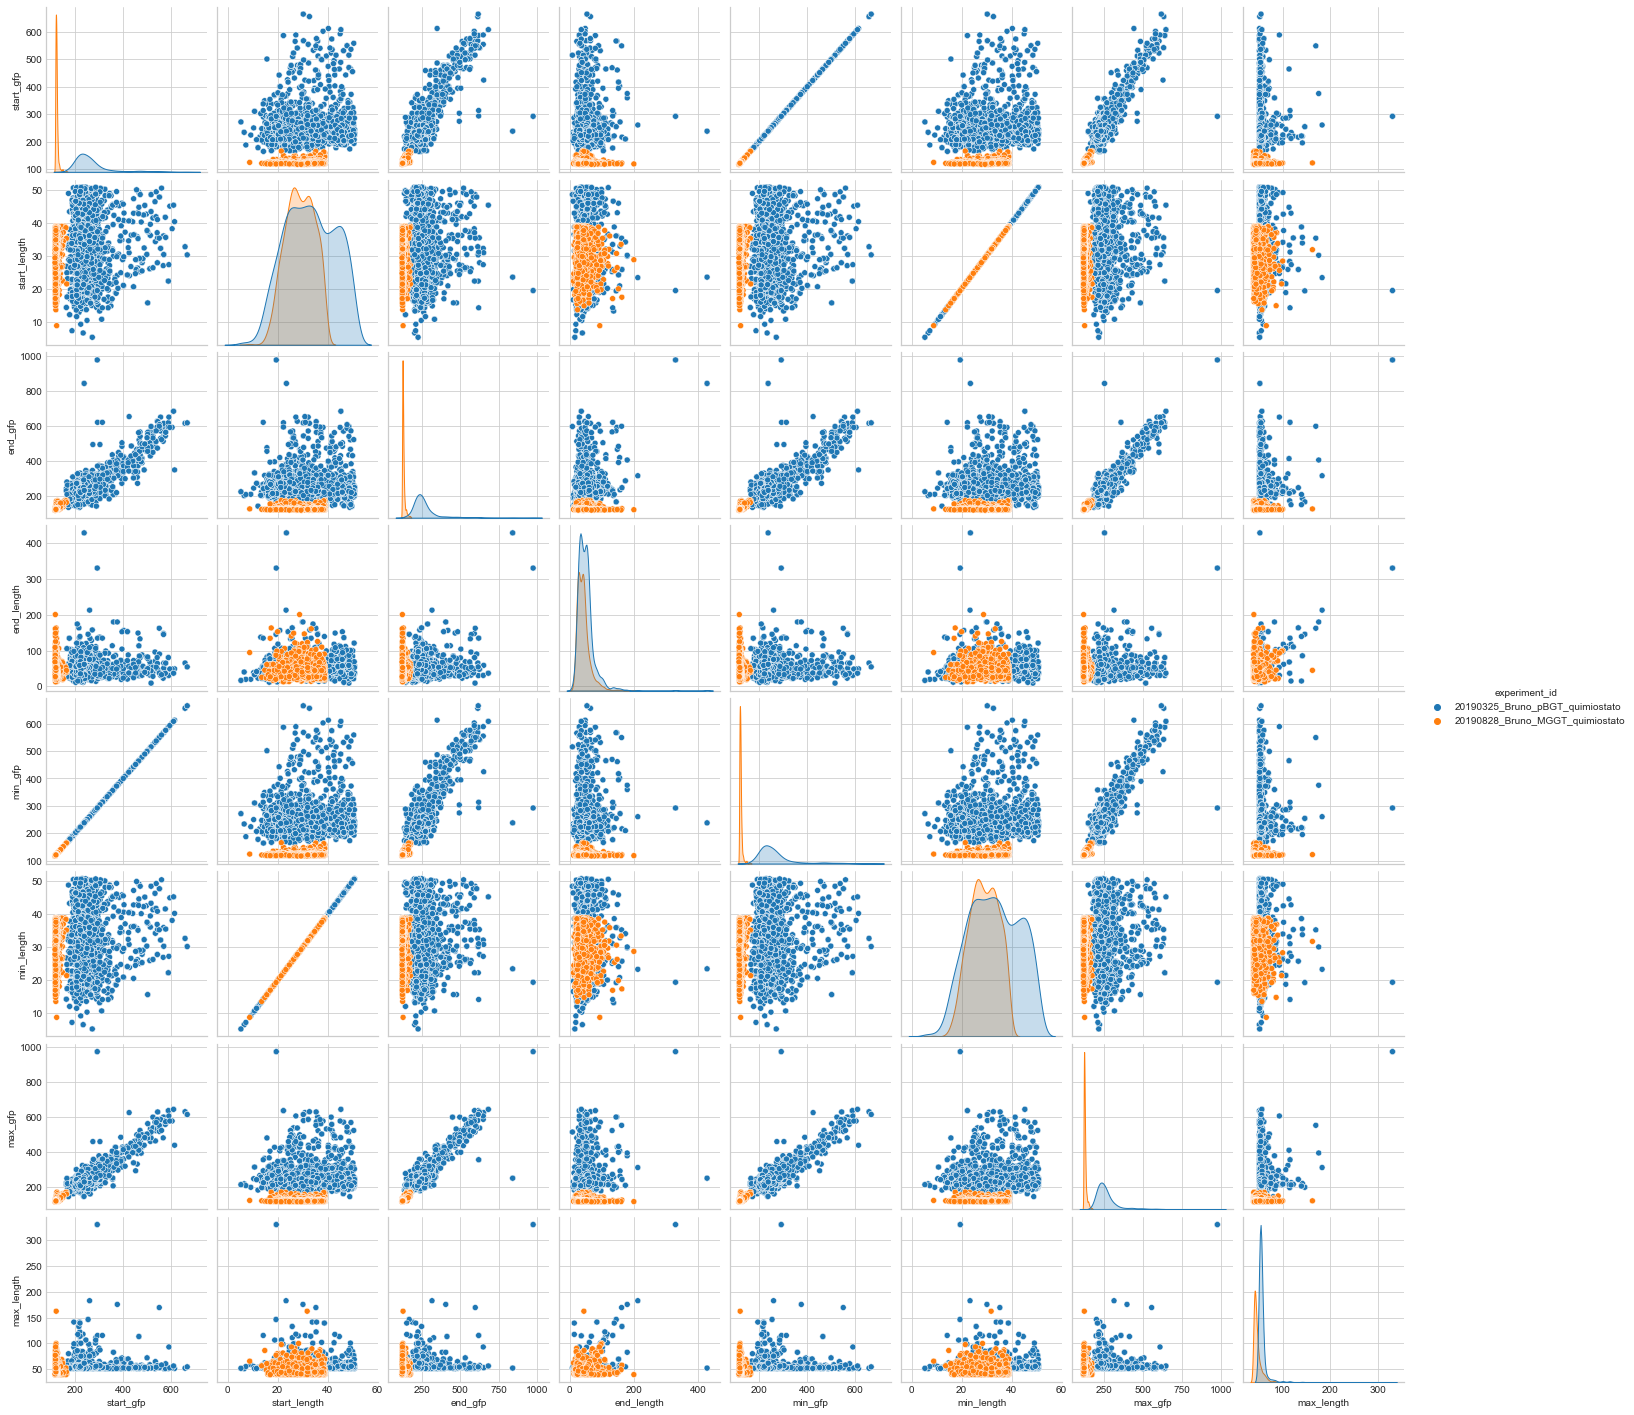

In [86]:
(
    results
    .select_columns(["*frame"], invert=True)
    .pipe(lambda df: sns.pairplot(data=df, hue="experiment_id"))
)

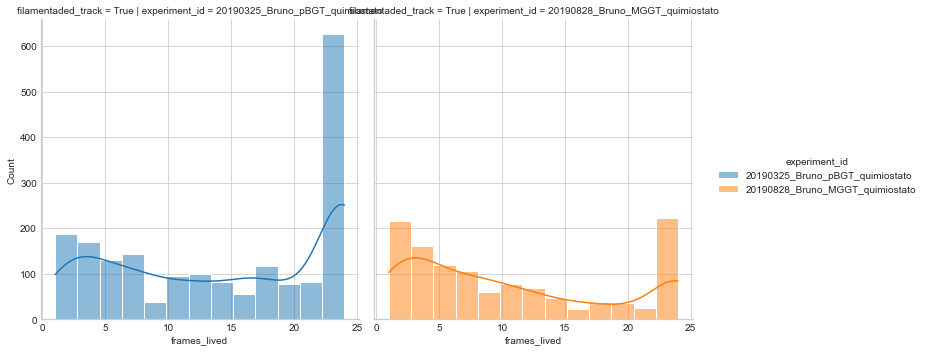

In [99]:
(
    results
    .assign(frames_lived = lambda df: df.end_centered_frame - df.start_centered_frame)
    .pipe(lambda df: sns.displot(data=df, x="frames_lived", hue="experiment_id", col="experiment_id", kde=True, row="filamentaded_track"))
)